In [1]:
from pathlib import Path

import joblib
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from sklearn import metrics
from sklearn import model_selection
from sklearn import tree

In [2]:
PATH = Path("results/3cat")
PATH.mkdir(exist_ok=True)

In [3]:
df = pd.read_csv("data/final_train.csv", index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


In [4]:
df = df.drop(columns=["subject", "void()"])
df = df.dropna()

In [5]:
y = df["Activity"]
X = df.drop(columns=["Activity"])
X.shape, y.shape

((9624, 569), (9624,))

In [6]:
is_walking = y.str.startswith("WALKING")
is_sit_stand = y.isin(["STANDING", "SITTING"])

y.loc[is_walking] = "WALKING_ALL"
y.loc[is_sit_stand] = "SIT/STAND"

/home/jdworzans/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
y.value_counts()

WALKING_ALL    4261
SIT/STAND      3542
LAYING         1821
Name: Activity, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [10]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

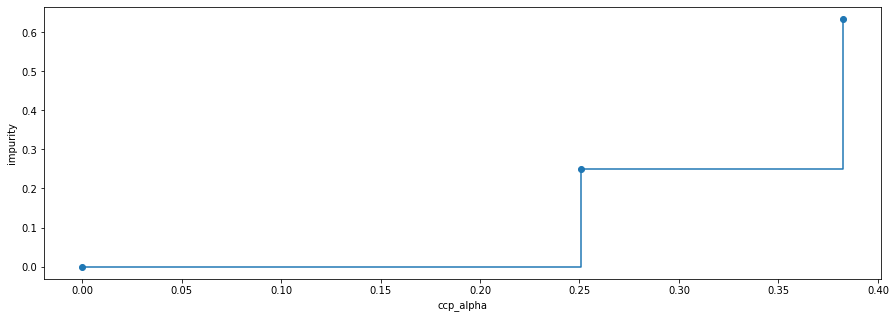

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("impurity")

fig.savefig(PATH / "impurity_vs_alpha.pdf")

plt.show()

In [12]:
clfs = [
    tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    for ccp_alpha in tqdm(ccp_alphas)
]

100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


In [13]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

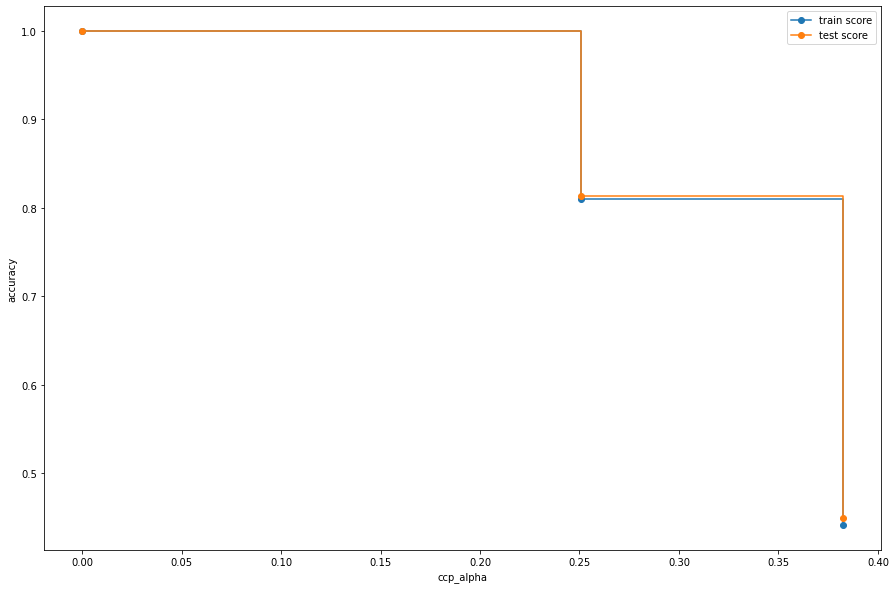

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(ccp_alphas, train_scores, marker='o', drawstyle="steps-post", label="train score")
ax.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post", label="test score")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("accuracy")

ax.legend()
fig.savefig(PATH / "accuracy_vs_alpha.pdf")

plt.show()

In [15]:
tree_clf.score(X_test, y_test)

1.0

In [16]:
dot_data = tree.export_graphviz(
    tree_clf,
    feature_names=X.columns,
    class_names=tree_clf.classes_,
    label="none",
    filled=True,
    leaves_parallel=True,
    impurity=False,
    rounded=True
)
graph = graphviz.Source(dot_data)
graph.render(PATH / "3cat_result.pdf")

'results/3cat/3cat_result.pdf.pdf'

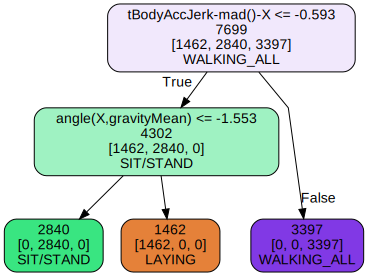

In [17]:
graph

In [18]:
joblib.dump(tree_clf, PATH / "tree.joblib")

['results/3cat/tree.joblib']

In [19]:
print(metrics.classification_report(y_test, tree_clf.predict(X_test)))

              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       359
   SIT/STAND       1.00      1.00      1.00       702
 WALKING_ALL       1.00      1.00      1.00       864

    accuracy                           1.00      1925
   macro avg       1.00      1.00      1.00      1925
weighted avg       1.00      1.00      1.00      1925



In [20]:
metrics.confusion_matrix(y_test, tree_clf.predict(X_test))

array([[359,   0,   0],
       [  0, 702,   0],
       [  0,   0, 864]])

In [21]:
tree_clf.tree_.feature

array([365,   0,  -2,  -2,  -2], dtype=int64)

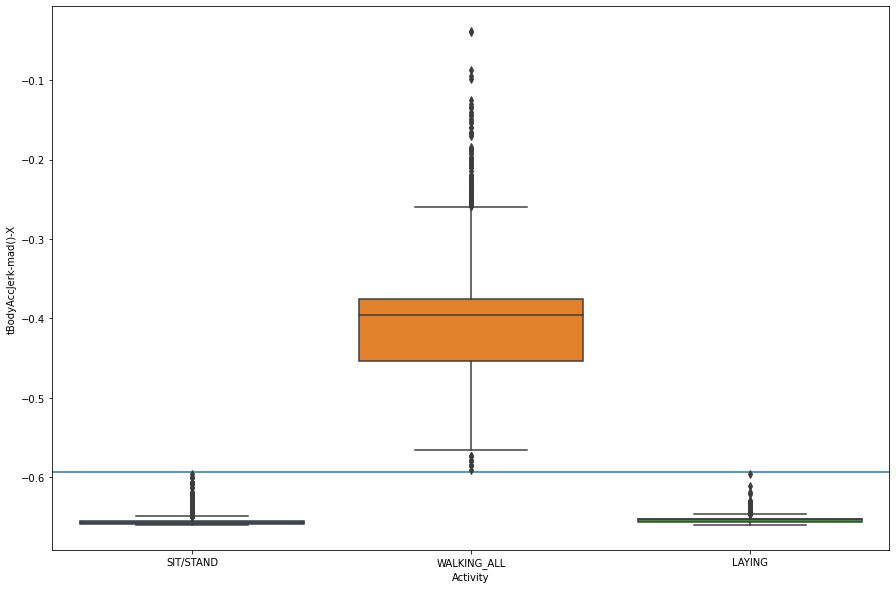

In [22]:
feature = X.columns[tree_clf.tree_.feature[0]]
threshold = tree_clf.tree_.threshold[0]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=feature, x=df["Activity"], data=X, ax=ax)
ax.hlines(threshold, *ax.get_xlim())

plt.show()

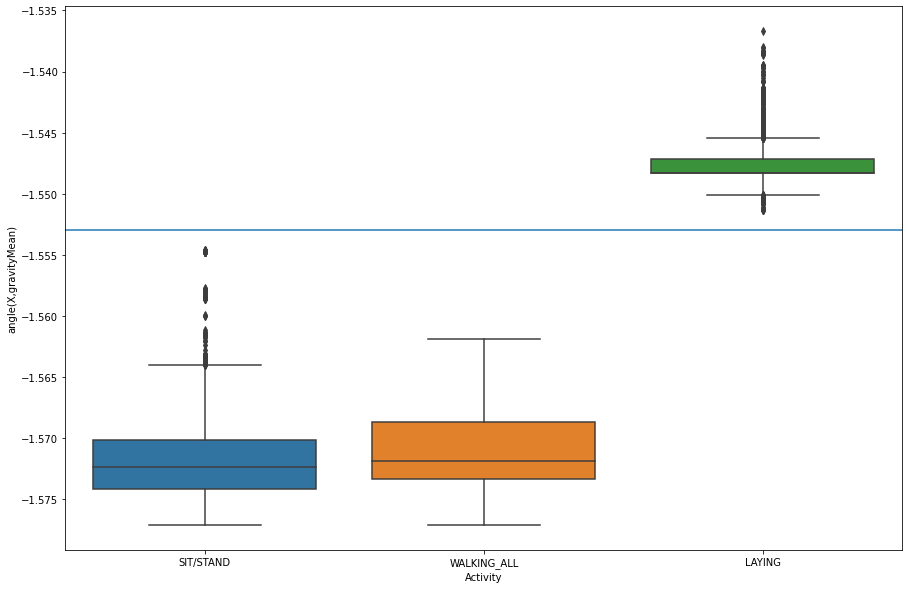

In [23]:
feature = X.columns[tree_clf.tree_.feature[1]]
threshold = tree_clf.tree_.threshold[1]

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y=feature, x=df["Activity"], data=X, ax=ax)
ax.hlines(threshold, *ax.get_xlim())

plt.show()